## Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load summary metrics file
summary_df = pd.read_csv('../data/derived/performance/summary.csv')

# preview dataframe
summary_df.sample(5)

,model_name,dataset_name,vector_name,hyperparameter_name,hyperparameter_value,metric_name,metric_value
841,svc,dev,lsi5,c,1,false_positives,139.000000
1851,decisiontree,dev,lsi5,maxdepth,None,false_negatives,188.000000
1936,svc,train,lsi100,c,0.1,accuracy,0.842389
600,svc,dev,lsi10,c,1,binary_precision,0.726397
1711,mlp,train,lsi100,alpha,0.01,false_negatives,291.000000


## Create line plot for given metric, model, and feature representation

In [3]:
def plot_performance(metric_name, model_name, vector_name):
    
    """
    Plot model performance on training and development datasets for given metric and feature representation 
    """
    
    # filter to relevant metric
    df = summary_df.copy()
    df = df[df['metric_name'] == metric_name]

    # extract y limits for metric of choice
    y_lim = (min(df['metric_value']), max(df['metric_value']))

    # filter to relevant feature representation and model type
    df = df[df['model_name']  == model_name]
    df = df[df['vector_name'] == vector_name]

    # add color mapping for each dataset
    df['dataset_color'] = ['tab:orange' if dataset == 'dev' else 'tab:blue' for dataset in df['dataset_name']]

    # get hyperparameter name (assumes only one hyperparameter tuned per model)
    hyperparameter_name = df['hyperparameter_name'].unique()[0]

    # sort dataframe by ascending hyperparameter value
    sorted_idx = np.argsort([float(x) if x.replace('.','',1).isnumeric() else float('inf') for x in df['hyperparameter_value']])
    df = df.iloc[sorted_idx, :]

    # set plot style
    plt.style.use('seaborn-whitegrid')

    # create figure
    fig, ax = plt.subplots(figsize = (4,3.25))

    # plot scatterplot
    ax.scatter(df['hyperparameter_value'], df['metric_value'], c=df['dataset_color'])

    # adjust labels
    ax.set_ylabel(vector_name)
    ax.set_xlabel(hyperparameter_name)
    ax.set_title(model_name)

    # adjust axes
    ax.set_ylim(y_lim)
    
    return fig

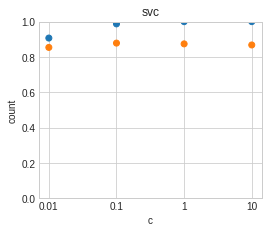

In [4]:
plot_performance('binary_f1', 'svc', 'count')
print()

## Visualize performance with line plots

In [5]:
def visualize_model_metric(summary_df, metric_name, model_name):
    """
    Print line graph of training and development performance for provided metric and model
    """
    
    # copy summary dataframe
    df = summary_df.copy()
    
    # filter dataframe to metric and model
    df = df[df['metric_name'] == metric_name]
    df = df[df['model_name']  == model_name]
    
    # reset indices
    df.reset_index(inplace=True, drop=True)
        
    # get hyperparameter name (assumes only one hyperparameter name per model)
    hyperparameter_name = df['hyperparameter_name'][0]
    
    # sort dataframe by vector name
    df.sort_values(by='vector_name', inplace=True)
    
    # sort dataframe by ascending hyperparameter value
    sorted_idx = np.argsort([float(x) if x.replace('.','',1).isnumeric() else float('inf') for x in df['hyperparameter_value']])
    df = df.iloc[sorted_idx, :]
    
    # set plot style
    sns.set_style("whitegrid")
    
    # plot decision tree performance
    g = sns.relplot(data = df,
                    x = 'hyperparameter_value',
                    y = 'metric_value',
                    hue = 'dataset_name', 
                    col = 'vector_name',
                    kind = 'line',
                    height = 2.25,
                    aspect = 2)
    
    # adjust labels
    g.set_titles("{col_name} vector")
    g.set_axis_labels(f'{hyperparameter_name}', f'{metric_name}')
    
    # adjust y-axis limit (uses hardcoded numbers)
    g.set(ylim=(0.5, None))
    
    return g.fig

In [6]:
def visualize_metric(summary_df, metric_name):
    """
    Print line graph of training and development performance for provided metric
    """
    visualize_model_metric(summary_df, metric_name, 'decisiontree')
    visualize_model_metric(summary_df, metric_name, 'mlp')
    visualize_model_metric(summary_df, metric_name, 'svc')
    return None

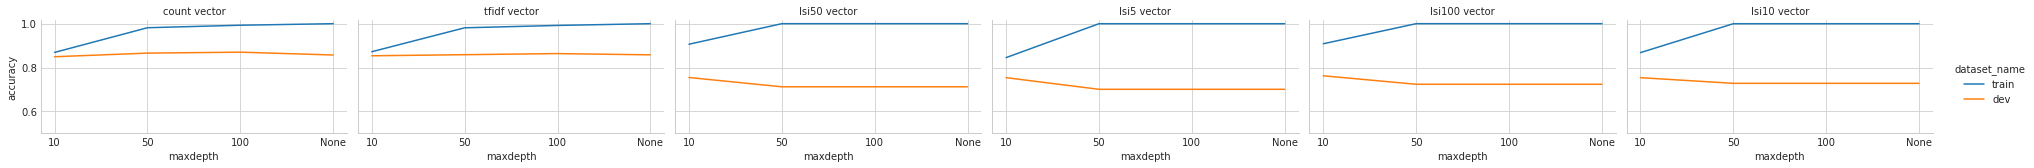

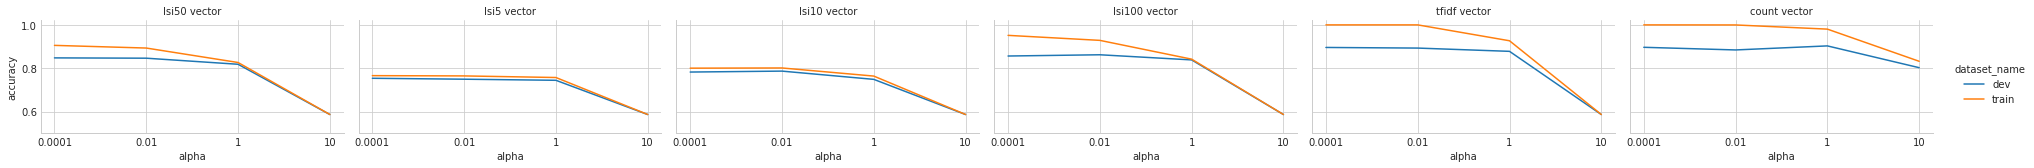

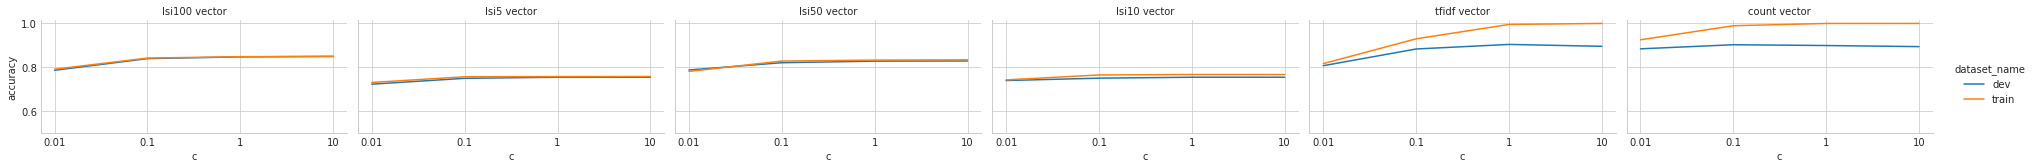

In [7]:
visualize_metric(summary_df, 'accuracy')

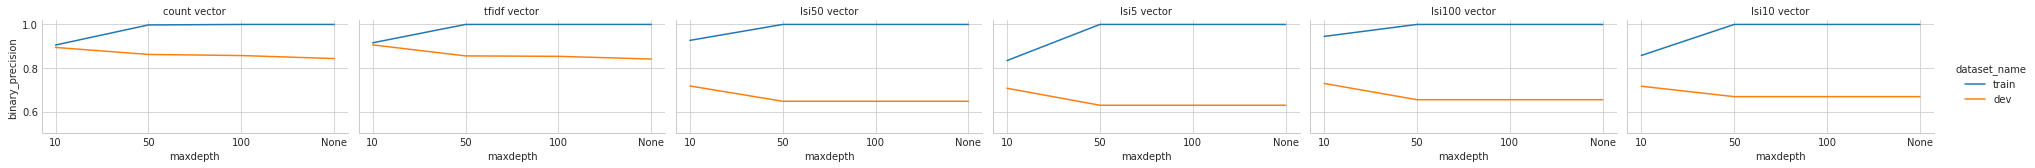

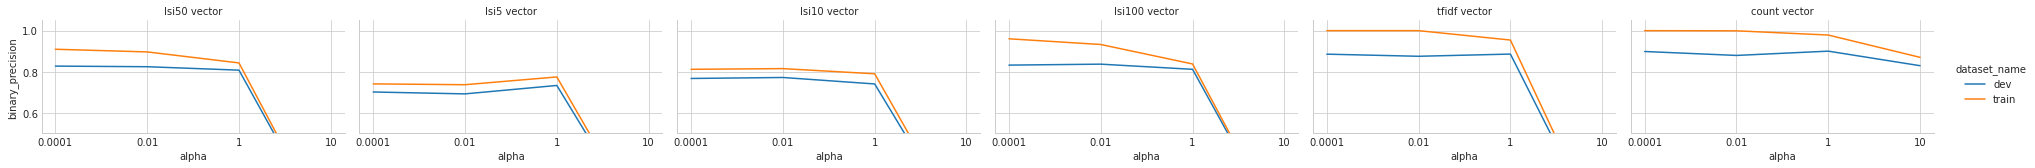

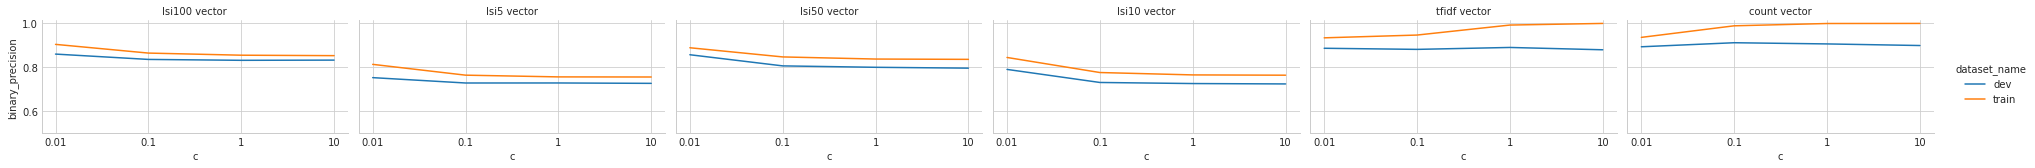

In [8]:
visualize_metric(summary_df, 'binary_precision')

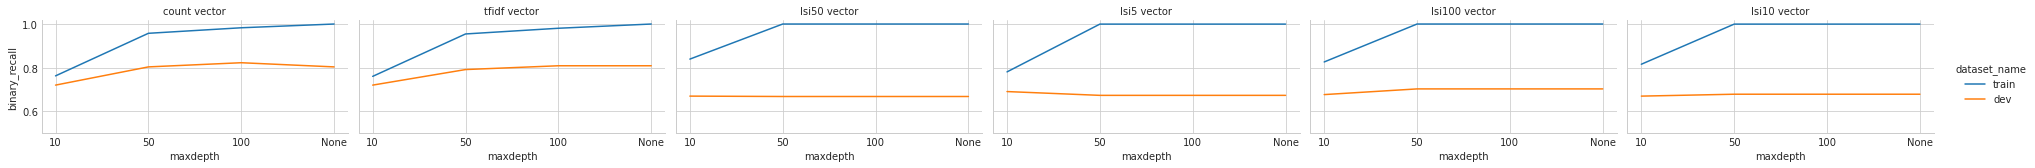

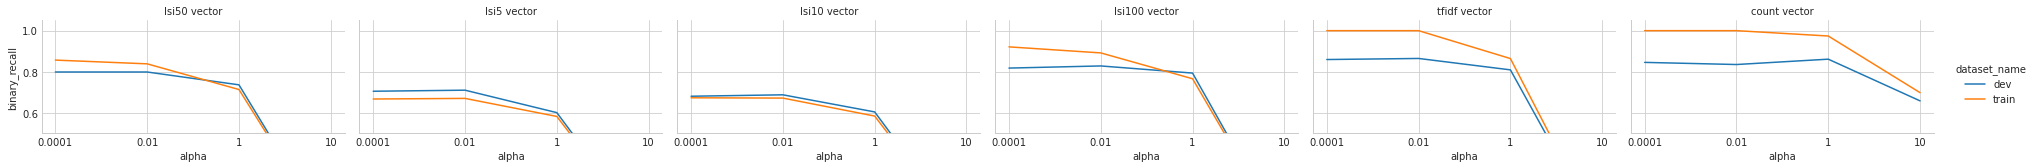

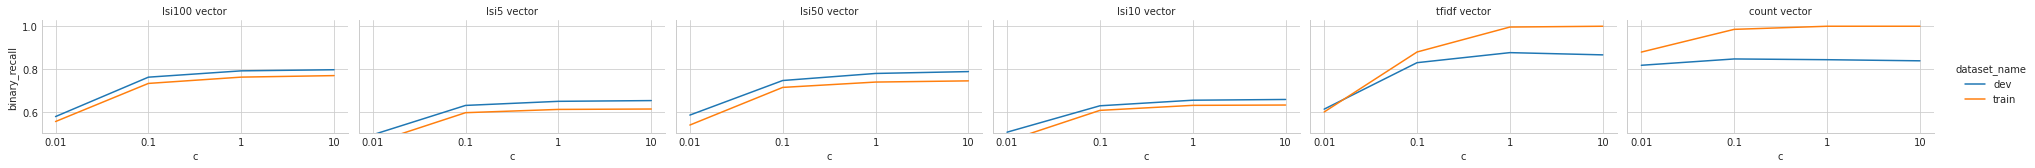

In [9]:
visualize_metric(summary_df, 'binary_recall')

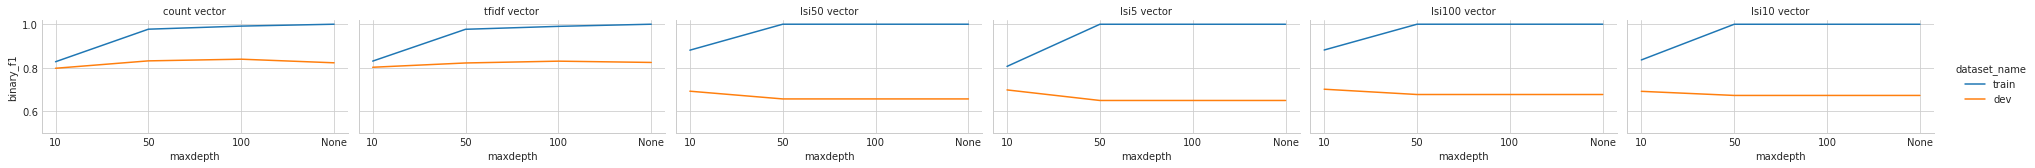

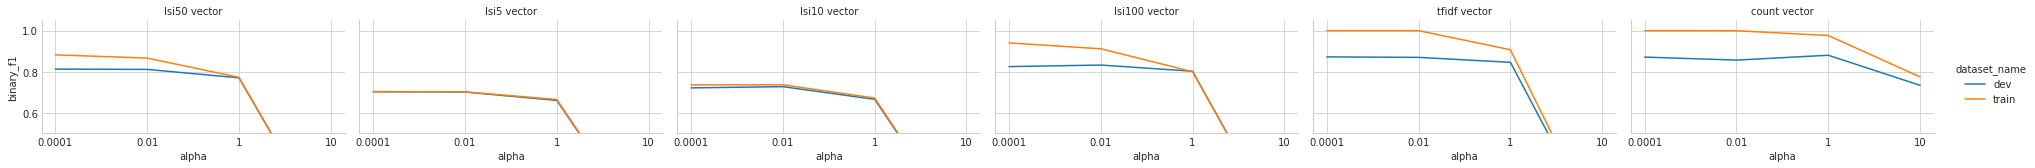

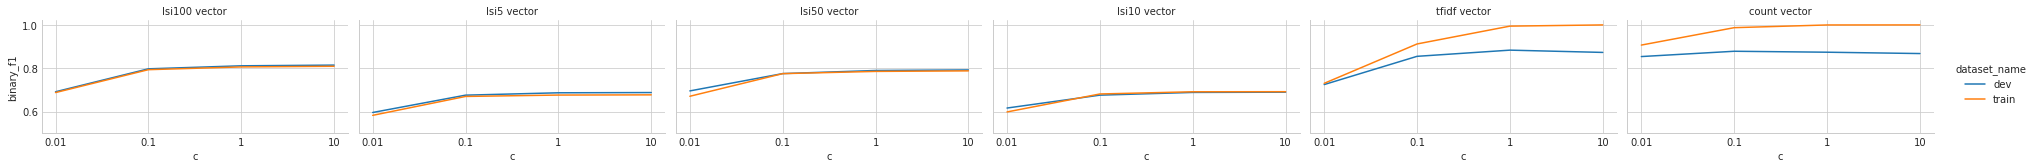

In [10]:
visualize_metric(summary_df, 'binary_f1')